In [10]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from IPython.display import display, HTML
from typing import List
from mprompt.modules.emb_diff_module import EmbDiffModule
import numpy as np
import matplotlib
import imodelsx.util
from copy import deepcopy
import re
import notebook_helper
import mprompt.viz
import scipy.special
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from mprompt.methods.m4_evaluate import D5_Validator
import openai
from mprompt.modules.fmri_module import fMRIModule

openai.api_key_path = os.path.expanduser('~/.OPENAI_KEY')


r = (pd.read_pickle('../results/results_fmri.pkl')
    .sort_values(by=['top_score_synthetic'], ascending=False))
r['id'] = "('" + r['top_explanation_init_strs'].str.replace(' ', '_').str.slice(stop=20) + "', '" + r['subject'] + "', " + r['module_num'].astype(str) + ")"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Select voxels

In [ ]:
# # display all rows
# with pd.option_context('display.max_rows', None, 'display.max_colwidth', 200):
#     display(r.sort_values(by=['top_score_synthetic'], ascending=False)[
#         ['top_explanation_init_strs', 'subject', 'module_num', 'top_score_synthetic', 'frac_top_ngrams_module_correct', 'id', 'top_ngrams_module_correct']
#     ].round(3).reset_index(drop=True).head(50))

In [11]:
# expls = ['baseball','animals','water','movement','religion','time','technology']
# interesting_expls = ['food', 'numbers', 'physical contact', 'time', 'laughter', 'age', 'clothing']
# voxels = [('movement', 'UTS01',	7), ('numbers', 'UTS03', 55), ('time', 'UTS03', 19), ('relationships', 'UTS01', 21),
        #   ('sounds', 'UTS03', 35), ('emotion', 'UTS03', 23), ('food', 'UTS03', 46)]
# voxels = [('numbers', 'UTS03', 55), ('time', 'UTS03', 19),
        #   ('sounds', 'UTS03', 35), ('emotion', 'UTS03', 23), ('food', 'UTS03', 46)]
# voxels = [('movement', 'UTS01',	7),('relationships', 'UTS01', 21) ('passing of time	UTS02	4)]
voxels = [('relationships', 'UTS02', 9), ('time', 'UTS02', 4), ('looking or staring', 'UTS03', 57)]

In [12]:
# convert voxels -> expl (and make sure it's corect)
rows = []
expls = []
for vox in voxels:
    expl, subj, vox_num = vox
    try:
        rows.append(r[(r.subject == subj) & (r.module_num == vox_num)].iloc[0])
        expls.append(expl)
    except:
        print('skipping', vox)
rows_check = pd.DataFrame(rows)
rows_check['expl'] = expls

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', 200):
    display(rows_check[['subject', 'module_num', 'expl', 'top_explanation_init_strs', 'top_ngrams_module_correct']])

,subject,module_num,expl,top_explanation_init_strs,top_ngrams_module_correct
62,UTS02,9,relationships,relationships and milestones in life,"[boyfriend of six, dating for months, boyfriend a year, married for fifteen, we got engaged, we were engaged, twenty he retired, a divorce twenty, virginity at twenty, am turning forty, daughter i..."
39,UTS02,4,time,passing of time,"[weeks became months, weekends became weeks, five years four, the moment passed, twenty minutes thirty, more time passed, replied age thirty, moment passed, later came the, days later diagnosed, m..."
28,UTS03,57,looking or staring,looking or staring in some way,"[eyed her suspiciously, at him incredulously, wink at, at me shyly, locks eyes with, staring at me, turned and saw, and mimed crying, incredulously like look, staring right at, point at a, leered ..."


# Generate story

In [ ]:
VERSION = 'v1'
PROMPTS = {
    'v0': {
        'PROMPT_FIRST_PREFIX': 'Write the beginning paragraph of a story about',
        'PROMPT_NEXT_PREFIX': 'Write the next paragraph of the story, but now make it about',
        'PROMPT_SUFFIX': ' "{expl}". Make sure it contains several references to "{expl}".',
    },
    'v1': {
        'PROMPT_FIRST_PREFIX': 'Write the beginning paragraph of a story told in first person. The story should be about',
        'PROMPT_NEXT_PREFIX': 'Write the next paragraph of the story, but now make it about',
        'PROMPT_SUFFIX': ' "{expl}". Make sure it contains several references to "{expl}".',
    },
}
PROMPT_FIRST_PREFIX = PROMPTS[VERSION]['PROMPT_FIRST_PREFIX']
PROMPT_NEXT_PREFIX = PROMPTS[VERSION]['PROMPT_NEXT_PREFIX']
PROMPT_SUFFIX = PROMPTS[VERSION]['PROMPT_SUFFIX']

# get a list of prompts
expls = [v[0] for v in voxels]
def get_prompts_basic(expls):
    prompt_init = PROMPT_FIRST_PREFIX + PROMPT_SUFFIX
    prompt_continue = PROMPT_NEXT_PREFIX + PROMPT_SUFFIX
    prompts = [prompt_init.format(expl=expls[0])] + [prompt_continue.format(expl=expl) for expl in expls[1:]]
    return prompts
prompts = get_prompts_basic(expls)
for p in prompts:
    print(p)

In [ ]:
# generate the paragraphs (these prefixes need get replace when the story is getting long)
paragraphs = mprompt.llm.get_paragraphs(prompts, PROMPT_FIRST_PREFIX=PROMPT_FIRST_PREFIX, PROMPT_NEXT_PREFIX=PROMPT_NEXT_PREFIX)
for para in paragraphs:
    print(para)

# Test synthetic data contains concept

In [ ]:
val = D5_Validator()

In [ ]:
# visualize single story
s = mprompt.viz.visualize_story_html(val, expls, paragraphs, prompts, fname='../results/story_running.html')
display(HTML(s))

In [ ]:
# compute scores heatmap
scores = notebook_helper.compute_expl_data_match_heatmap(val, expls, paragraphs)

In [ ]:
s = scores
# s = scipy.special.softmax(scores, axis=1)
# s = (s - s.min()) / (s.max() - s.min())
mprompt.viz.heatmap(scores, expls)

# Test modules on the generated stories

In [13]:
scores, scores_max, all_scores, all_ngrams = notebook_helper.compute_expl_module_match_heatmap(expls, paragraphs, voxels)

  0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [01:21<02:43, 81.97s/it]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [02:36<01:17, 77.55s/it]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 3/3 [03:50<00:00, 76.83s/it]


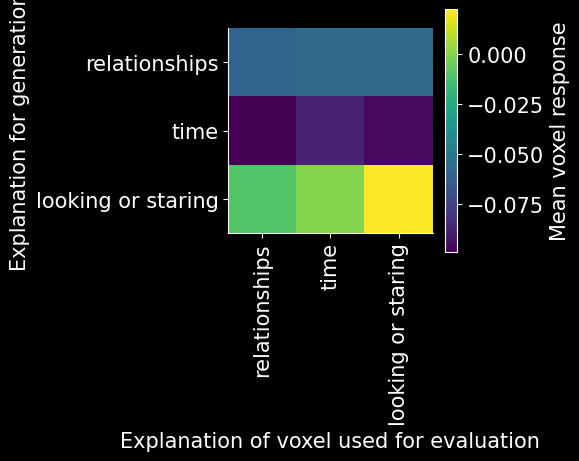

In [14]:
s = scores
s = scipy.special.softmax(scores, axis=1)
# s = (s - s.min()) / (s.max() - s.min())
mprompt.viz.heatmap(scores, expls, xlab='Explanation of voxel used for evaluation', clab='Mean voxel response')

### Module responses for single story

In [ ]:
pd.set_option('display.max_rows', 120)
for i in range(1): #len(voxels)):
    row = rows_check.iloc[i]
    display(row[['subject', 'module_num', 'top_explanation_init_strs', 'explanation_init_ngrams', 'top_ngrams_module_correct']])
    mod = fMRIModule(voxel_num_best=row.module_num, subject=row.subject)
    # show all rows
    # display(
    #     pd.DataFrame.from_dict({
    #         'score': all_scores[i][i],
    #         'ngram': all_ngrams[i][i],
    #     }).sort_values('score', ascending=False).head(10)
    # )

In [ ]:
x = row['explanation_init_ngrams']
p = mod(x)


In [ ]:
out = mod(x, return_all=True)
scores = row['explanation_init_outputs']

In [ ]:
p = out[:, row.module_num]